In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/beans/bespoke')

from constants import *
from imports import *
from viz_utils import *
from traj_utils import *

/home/beans/anaconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(
/home/beans/anaconda3/envs/py38/lib/python3.8/site-packages/albumentations/augmentations/transforms.py:965: FutureWarning: This class has been deprecated. Please use ImageCompression
  warnings.warn(


In [2]:
chunks_range = range(SEQ_LEN-1, EPISODE_LEN, SEQ_LEN)

In [5]:
run_paths = glob.glob("/home/beans/blender_membank/*/run*", recursive=True)

In [4]:
run_path = random.choice(run_paths)

aux = np.concatenate([np.load(f'{run_path}/aux_{i}.npy') for i in chunks_range], axis=0)
targets = np.concatenate([np.load(f'{run_path}/targets_{i}.npy') for i in chunks_range], axis=0)
maps = np.concatenate([np.load(f'{run_path}/maps_{i}.npy') for i in chunks_range], axis=0)

targets[:-1,:] = targets[1:,:] #TODO this should be moved further upstream, remove from here
aux[:-1,:] = aux[1:,:] # NOTE this stagger is verified correct
#maps[:-1,:,:,:] = maps[1:,:,:,:]

targets_all = targets
targets, wp_dists, wp_rolls, wp_z = np.split(targets_all, 4, axis=1)

aux.shape, targets.shape, wp_dists.shape, wp_z.shape, maps.shape, run_path

IndexError: Cannot choose from an empty sequence

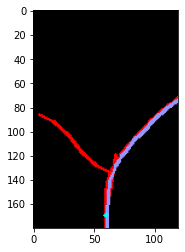

In [95]:
plt.imshow(maps[500])

In [96]:
speeds = aux[:,2]
wp_angles = gather_preds(targets, speeds)

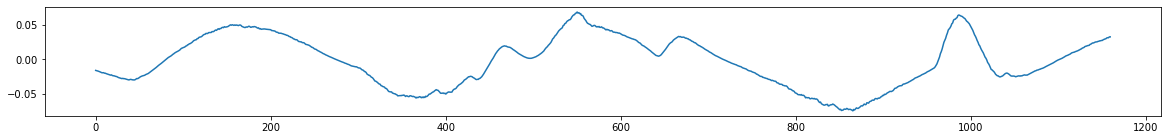

In [97]:
# steer
plt.figure(figsize=(20,2))
plt.plot(wp_angles)

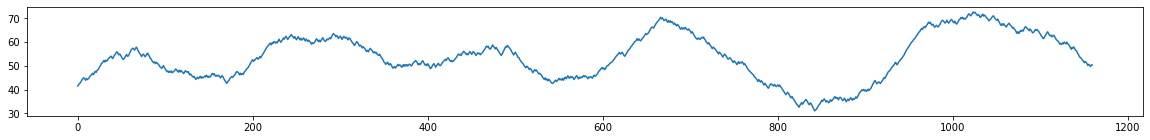

In [98]:
plt.figure(figsize=(20,2))
plt.plot(speeds)

In [99]:
ix = 100

In [100]:
t = smooth_near_wps(targets[ix])

In [101]:
xs_smoothed = np.sin(t) * wp_dists[ix]
ys_smoothed = np.cos(t) * wp_dists[ix]

xs = np.sin(targets[ix]) * wp_dists[ix]
ys = np.cos(targets[ix]) * wp_dists[ix]

In [102]:
headings_smoothed = get_headings_from_traj(t, wp_dists[ix])
headings = get_headings_from_traj(targets[ix], wp_dists[ix])

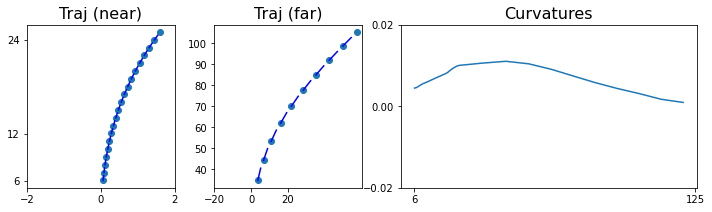

In [103]:
fig = get_pts_and_headings_fig(t, wp_dists[ix], headings_smoothed, get_curvatures_from_headings(smooth_near_wps(headings_smoothed)))

<BarContainer object of 10 artists>

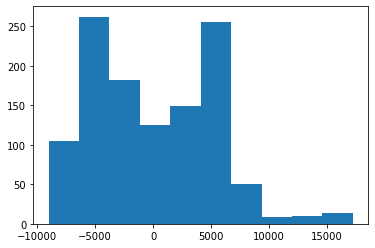

In [104]:
# Torque
torque = np.degrees(wp_angles) * speeds**2
plt.hist(torque)[2]

<BarContainer object of 10 artists>

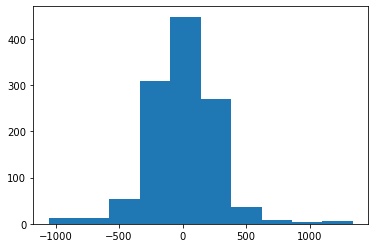

In [105]:
plt.hist(torque[1:]-torque[:-1])[2]

In [106]:
img_paths = sorted(glob.glob(f"{run_path}/imgs/*"))

In [107]:
%%time

imgs = [cv2.imread(i)[:,:,::-1] for i in img_paths]
imgs = np.stack(imgs).astype(np.uint8)

CPU times: user 11.8 s, sys: 6.47 s, total: 18.3 s
Wall time: 18.6 s


In [108]:
"""plt.figure(figsize=(20,4))
ix = 800
plt.imshow(imgs[ix])"""
"""plt.figure(figsize=(20,4))
g = .7
plt.imshow((imgs[ix]*g).astype(int) + (imgs[ix-4]*(1-g)).astype(int))"""

'plt.figure(figsize=(20,4))\ng = .7\nplt.imshow((imgs[ix]*g).astype(int) + (imgs[ix-4]*(1-g)).astype(int))'

In [109]:
for i in range(len(imgs)):
    imgs[i,-MAP_HEIGHT:,-MAP_WIDTH:,:] = maps[i]

In [110]:
height, width, channels = cv2.imread(img_paths[0]).shape #processed_imgs[0].shape
w2 = width//2
h2 = height//2

fps = 20

video = cv2.VideoWriter(f'/home/beans/bespoke_vids/sim_simple.avi', cv2.VideoWriter_fourcc(*"MJPG"), fps, (width,height))

for i in range(len(img_paths)-1):

    img = imgs[i]
    
    # wps
    img = draw_wps(img, targets[i])
     
    # Guidelines
    img[:,w2-1:w2+1,:] -= 20 # darker line vertical center
    img[h2-1:h2+1:,:,:] -= 20 # darker line horizontal center
        
    video.write(img)
    
video.release()

In [111]:
%%time

from viz_utils import make_vid

aux_vid = aux.copy()
#aux_vid[:,:2] = 0 # zeroing out pitch and yaw

run_id = "sim"
model_stem = "12.15_e15"
rollout_data = make_vid(run_id, 
                        model_stem, 
                        imgs, 
                        aux_vid, 
                        targets=targets, 
                        add_charts=False)

(1157, 30) (1157, 1, 45, 180) (1157, 1, 45, 180)
720 1490 3
Made vid!
CPU times: user 23min 10s, sys: 1min 48s, total: 24min 58s
Wall time: 3min 1s


In [112]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, pred_aux_all, cnn_activations, cnn_grads, \
        rnn_activations, rnn_grads, stop_cnn_grads, lead_cnn_grads = rollout_data

In [113]:
pred_aux_all.shape

(1157, 12)

In [114]:
aux_model, aux_calib, aux_targets = get_auxs(pad(aux))
aux_model.shape, aux_calib.shape, aux_targets.shape

((1, 1160, 5), (1, 1160, 4), (1, 1160, 12))

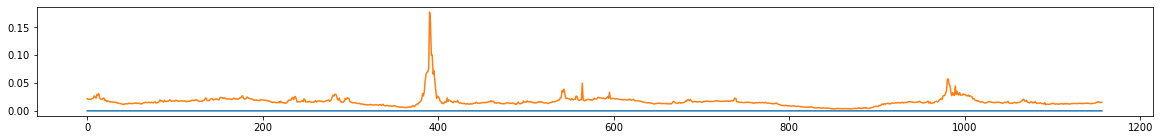

In [115]:
# Approaching stop

plt.figure(figsize=(20,2))
plt.plot(aux_targets[0,:,0][SEQ_START_IX:])
plt.plot(sigmoid_python(pred_aux_all[:,0]))

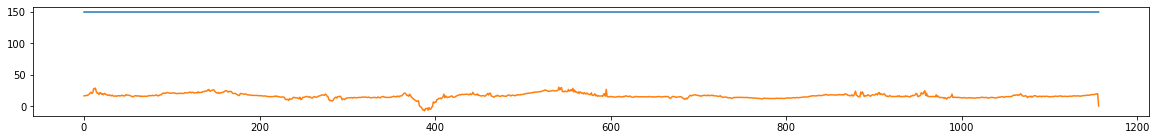

In [116]:
# stop dist

plt.figure(figsize=(20,2))
plt.plot(aux_targets[0,:,1][SEQ_START_IX:])
plt.plot(pred_aux_all[:,1])

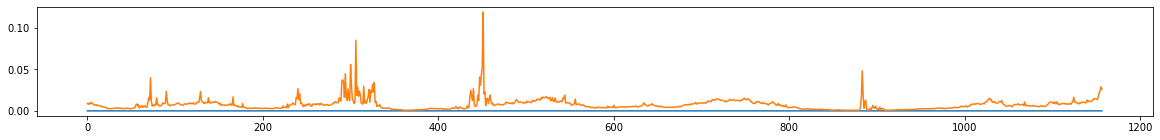

In [117]:
# has lead

plt.figure(figsize=(20,2))
plt.plot(aux_targets[0,:,3][SEQ_START_IX:])
plt.plot(sigmoid_python(pred_aux_all[:,3]))

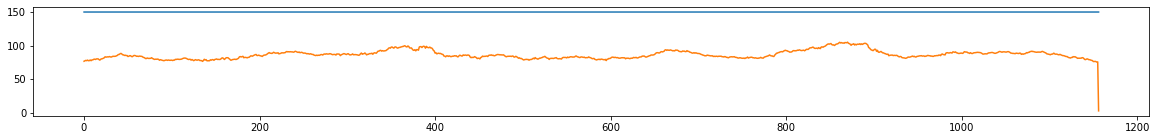

In [118]:
# lead dist

plt.figure(figsize=(20,2))
plt.plot(aux_targets[0,:,4][SEQ_START_IX:])
plt.plot(pred_aux_all[:,4])

In [35]:
#combine_vids("8.9_avg", "8.9_avgTrain", "sim")

In [36]:
#p = get_viz_rollout(model_stem, imgs, aux_vid, do_gradcam=False)
#wp_angles_all, wp_headings_all, wp_curvatures_all, _, _, _, _, _ = p

In [37]:
wp_angles_all, wp_headings_all, wp_curvatures_all, obsnet_outs, cnn_activations, cnn_grads, rnn_activations, rnn_grads = rollout_data

NameError: name 'rollout_data' is not defined

(array([ 262.,  382.,  354.,  193.,  881.,  984., 1261., 1231.,  211.,
          41.]),
 array([-6.6448742e-04, -5.0002674e-04, -3.3556606e-04, -1.7110539e-04,
        -6.6447187e-06,  1.5781596e-04,  3.2227664e-04,  4.8673732e-04,
         6.5119797e-04,  8.1565866e-04,  9.8011934e-04], dtype=float32),
 <BarContainer object of 10 artists>)

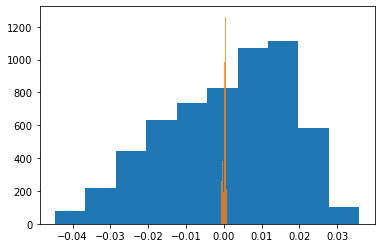

In [50]:
plt.hist(targets[:,:5].flatten())
plt.hist(wp_angles_all[:,:5].flatten(), alpha=.8)

In [22]:
obsnet_outs.shape

(1160, 3)

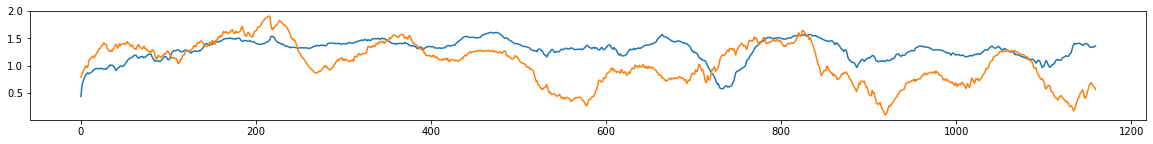

In [23]:
plt.figure(figsize=(20,2))
plt.plot(obsnet_outs[:,1])
plt.plot(obsnet_outs[:,2])

In [24]:
aux[0]

array([7.9585475e-01, 1.5869594e+00, 4.5101814e+01, 0.0000000e+00,
       3.2588083e-03], dtype=float32)